## Installation

In [1]:
# # install package dependencies Seurat, scLink and dplyr
# install.packages('scLink',version='1.0.1')
# install.packages('dplyr')
# remotes::install_version("Seurat", "4.4.0")

In [2]:
# library(devtools)
# install_github("KChen-lab/transition-cells-identification",force=T)

In [3]:
library(CellTran)
options(warn=-1)

## Read data

,orig.ident,nCount_RNA,nFeature_RNA,ClusterName
,<fct>,<dbl>,<int>,<chr>
10X84_2:AAATGCCAGGTGCTAGx,10X84,110.42559,127,RadialGlia
10X84_2:AAACCTGAGTTGAGTAx,10X84,81.33175,57,ImmGranule1
10X84_2:AACACGTGTTATCGGTx,10X84,96.75255,71,ImmGranule1
10X84_2:AAAGTAGAGCTCAACTx,10X84,126.87516,162,Granule
10X84_2:AAACCTGTCCTTTACAx,10X84,103.83191,93,ImmGranule2
10X84_2:AAACCTGGTCGCTTCTx,10X84,119.08071,112,Nbl1


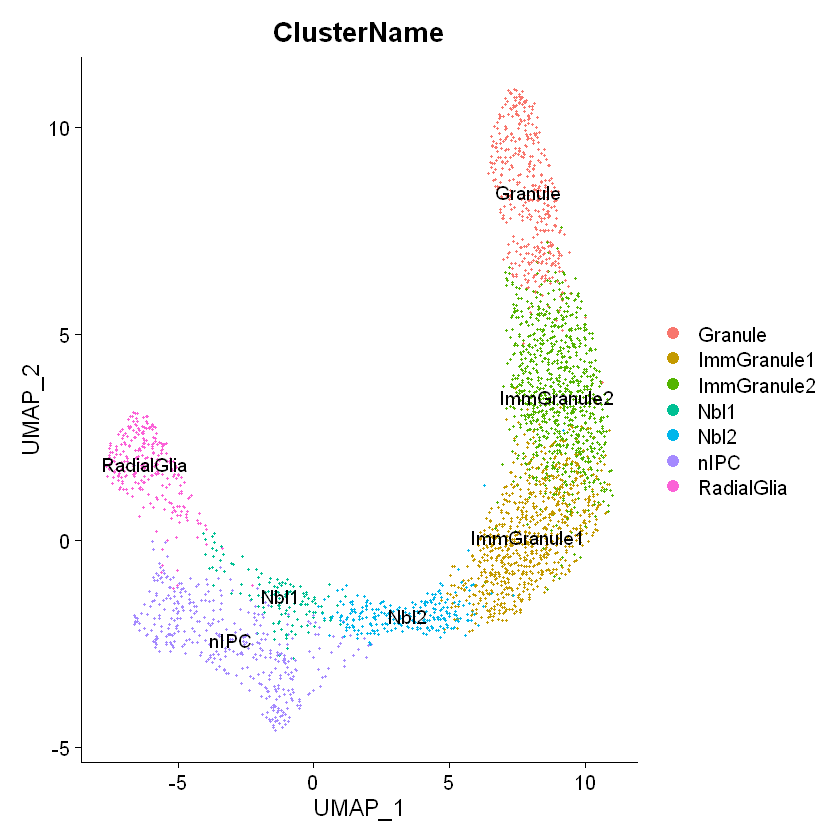

In [ ]:
library(Seurat)
library(dplyr)

data_name = 'DG'

# (1) 读取表达矩阵（自动生成行名 "1", "2", "3"...）
counts <- read.csv(paste(data_name, "X.csv", sep = "/"), row.names = 1)  # 假设第一列是基因名

# (2) 创建 Seurat 对象
data <- CreateSeuratObject(
  counts = t(counts),          # Seurat 要求行=基因，列=细胞（需转置）
)

# (3) 添加 PCA 坐标
pca <- read.csv(paste(data_name, "pca.csv", sep = "/"), row.names = 1)
data[["pca"]] <- CreateDimReducObject(
  embeddings = as.matrix(pca), # PCA 坐标矩阵
  key = "PC_",                 # 坐标列名前缀（如 PC_1, PC_2）
  assay = "RNA"                # 关联到 RNA assay
)

# (4) 添加 UMAP 坐标
umap <- read.csv(paste(data_name, "umap.csv", sep = "/"), row.names = 1)
data[["umap"]] <- CreateDimReducObject(
  embeddings = as.matrix(umap),
  key = "UMAP_",               # 坐标列名前缀（如 UMAP_1, UMAP_2）
  assay = "RNA"
)

# (5) 添加聚类标签
clusters <- read.csv(paste(data_name, "ClusterName.csv", sep = "/"), row.names = 1)
data <- AddMetaData(
  object = data,
  metadata = clusters,
  col.name = "ClusterName"     # 元数据列名
)

# (6) 设置默认聚类标识
Idents(data) <- "ClusterName"  # 后续分析默认按此分组

# 查看结果
head(data@meta.data)
DimPlot(data, reduction = "umap", group.by = "ClusterName", label = TRUE)

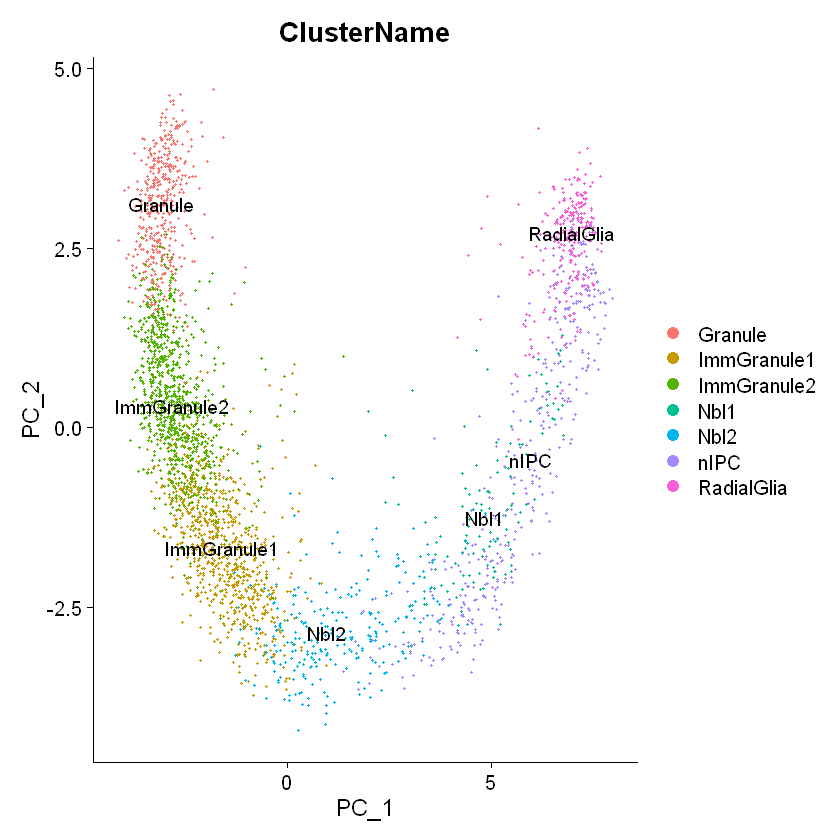

In [16]:
DimPlot(data, reduction = "pca", group.by = "ClusterName", label = TRUE)

In [17]:
data<- NormalizeData(data)
data<- ScaleData(data)
# data<- RunPCA(data, features = rownames(data))
data<- FindNeighbors(data, dims = 1: 5)
data<- FindClusters(data, resolution = 0.5)
# data<- RunUMAP(data,dims=1:5)

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3139
Number of edges: 98058

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8783
Number of communities: 10
Elapsed time: 0 seconds


In [18]:
data

An object of class Seurat 
678 features across 3139 samples within 1 assay 
Active assay: RNA (678 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

# Calculate transition index

In [20]:
#' Calculate GPPCCs
#'
#' This is the function calculating gene pair-wise Pearson's correlation coefficients (GPPCCs). 
#' The GPPCCs calculated using our method are assumed from the cells that exhibit similar 
#' regulatory profiles and around equilibrium points. Thus, for each cell, we select the cell 
#' together with its nearest neighbors in Principal Component Analysis (PCA) dimensions based 
#' on cosine distance to calculate GPPCCs. We also use scLink in the calculation to deal with
#' the gene expression values affected by dropout. 
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @return A matrix of GPPCCs. Rows are cells and columns are gene pairs.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
gene_pearson<-function(data,highly_variable_gene=NULL,n_neighbor=300,n_gene=50,...){
        res<-NULL
        exprs<-as.matrix(GetAssayData(data))
        if(is.null(highly_variable_gene)){
                highly_variable_gene<-order(apply(as.matrix(exprs),1,function(x) var(x)),decreasing=T)[1:n_gene]
                highly_variable_gene<-rownames(exprs)[highly_variable_gene]
        }
        for(c in data %>% colnames()){
                expr<-t(exprs[highly_variable_gene,data@neighbors$RNA.nn@nn.idx[match(c,data@neighbors$RNA.nn@cell.names),]])
                pearson_cor<-scLink::sclink_cor(expr = expr, ncores = 1)
                diag(pearson_cor)<-NA
                res<-rbind(res,as.numeric(pearson_cor))
        }
        rownames(res)<-colnames(data)
        gene_name<-highly_variable_gene
        name_tmp<-character()
        for(i in gene_name){
                for(j in gene_name)
                        name_tmp<-c(name_tmp,paste(i,j,sep='_'))
         }
        colnames(res)<-name_tmp
        return(res)
}


find_ks_d<-function(x,y){
        n.x <- length(x)
        n.y <- length(y)
        w <- c(x, y)
        z <- cumsum(ifelse(order(w) <= n.x, 1/n.x, -1/n.y))
        w_sort<-sort(w)
        w_max<-max(w_sort[z==max(z)])
        z_sub<-z[w_sort>w_max]
        w_min<-min(w_sort[w_sort>w_max][z_sub==min(z_sub)])
        return(list('w_min'=w_min,'w_max'=w_max))
}

#' Calculate transition index
#'
#' This is the function calculating transition index that reflects the transition
#' probability of a cell. The transition index we defined is inspired by Kolmogorov-Smirnov 
#' statistic. We assume there are both transition cells and stable cells captured by  
#' scRNA-seq in the data. We first find the archetype of transition 
#' cell and stable cell by using modified Kolmogorov-Smirnov statistic. As proved 
#' mathematically, there are more gene pairs whose absolute value of Pearson鈥檚 
#' correlation coefficients are close to 1 in transition cells than stable cells. 
#' Thus, based on the distribution difference, by finding the maximum difference 
#' among all cells, we identify archetypal stable cells and transition cells. To 
#' count and compare the number of gene pairs exceeding such threshold in each cell, 
#' we define transition index by summarizing the percentage of gene pairs whose 
#' absolute value of Pearson鈥檚 correlation coefficients are between argmax_x(D_max)    
#' and argmin_x(D_max). 
#'
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param group The cell group highly_variable_genes selected based on. It should be a column
#' name of data@meta.data, such as 'seurat_clusters','cell_type','time_point'. Using 
#' 'seurat_clusters' by default. 
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @param n_gene The number of top most variable genes used in calculating GPPCCs. 50 by default.
#' @param return_pearson Whether report GPPCCs or not. Using False by default.
#' @return If return_pearson is False, return a Seurat object. Calculated transition index is 
#' store as a column in the metadata. If return_pearson is True, return a list. Calculated 
#' transition index is stored in the data element, as a column in the metadata. GPPCCs is stored
#' in the GPPCCs element.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
transition_index<-function(data,highly_variable_gene=NULL,group='seurat_clusters',n_neighbors=300,n_gene=50,return_pearson=FALSE,...){
    res<-list()
    for(i in data@meta.data[,group] %>% unique()){
            print(i)
            data_sub<-data[,data@meta.data[,group]==i]
            if(ncol(data_sub)<=n_neighbors)
                    next
            data_sub<-Seurat::FindVariableFeatures(data_sub, selection.method = "vst", nfeatures = 2000)
            data_sub<- Seurat::ScaleData(data_sub,vars.to.regress="nCount_RNA")
            data_sub<- Seurat::RunPCA(data_sub, features = VariableFeatures(object = data_sub),npcs=min(20,ncol(data_sub)))
            data_sub<- Seurat::FindNeighbors(data_sub, dims = 1: min(20,ncol(data_sub)),return.neighbor = TRUE,k.param=n_neighbors,annoy.metric='cosine')
            pearson<-gene_pearson(data_sub,highly_variable_gene=highly_variable_gene,n_neighbor=n_neighbors,n_gene=n_gene)
            # fine tuning  (optional)
            pearson<-abs(pearson)
            res_1<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='greater')$statistic)
            res_2<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='less')$statistic)
            res_tmp<-find_ks_d(pearson[which.max(res_1),],pearson[which.max(res_2),])
            tmp<-apply(pearson,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
            data_sub<-Seurat::AddMetaData(data_sub,data.frame('pearson'=tmp))
            if(min(tmp)==max(tmp)){
                    res[[as.character(i)]]<-pearson
                    next
            }
            cell<-data_sub@meta.data %>% dplyr::filter(pearson>quantile(data_sub$pearson,0.8,na.rm=T)) %>% rownames()
            hvg<-sort(apply(as.matrix(GetAssayData(data_sub[,cell])),1,function(x) var(x)),decreasing=T)[1:n_gene] %>% names
            pearson<-gene_pearson(data_sub,n_neighbor=n_neighbors,highly_variable_gene=hvg)
            res[[as.character(i)]]<-pearson
    }
    res<-Reduce(function(x,y) rbind(x,y),res)
    pearson<-res
    res<-abs(res)
    res_1<-apply(res,1,function(x) ks.test(x,res[1,],alternative='greater')$statistic)
    res_2<-apply(res,1,function(x) ks.test(x,res[1,],alternative='less')$statistic)
    res_tmp<-find_ks_d(res[which.max(res_1),],res[which.max(res_2),])
    tmp<-apply(res,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
    data<-Seurat::AddMetaData(data,data.frame('transition_index'=tmp))
    if(!return_pearson)
    return(data)
    else
    return(list('GPPCCs'=pearson,'data'=data))
}


In [21]:
# calculate transition index
data<-transition_index(data,n_neighbor=50,n_gene=100)

[1] "5"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Fabp7, Ptpre, Ptpn5, Timp3, Pea15a, Tspan7, Ptn, Pcdh19, Slc6a15, Dlgap1 
	   Kcnq2, Prex1, Slc1a3, Lrrn2, Gabrb1, Lmtk3, Rasgrf1, Slc6a7, Tnc, Clu 
	   Sparcl1, Ryr2, Car2, S100a6, Aqp4, Mdga1, Ptprz1, Pcsk2, Kcnj4, Arpp21 
Negative:  Rpl32, Mcm6, Tesc, Dhfr, Ran, Chd7, Cdt1, Ndufc2, Tpx2, Ccne2 
	   Elavl4, Ckap2, Lima1, Siva1, Tox3, Mcm3, Anp32b, Cdca7, Hmgn1, Ranbp1 
	   Trp53i11, Ezh2, Mt2, Ccdc34, Cenpk, Sgol1, Nasp, Nme4, Dtl, Dut 
PC_ 2 
Positive:  Fabp7, Plpp3, Cd63, Car2, Ptn, Nkain4, Lxn, Msmo1, Uhrf1, Pea15a 
	   Cyr61, Rpa2, Pon2, Mlc1, Mfap3l, Oat, Ramp1, Frzb, Ctnnbip1, Top2a 
	   Csrp1, Sparcl1, Galnt16, Glud1, Dut, S100a6, Emid1, Cspg5, Pcna, Cd9 
Negative:  Mdga1, Kcnj4, Ryr2, Caly, Rasgrf1, Pcdh19, Slc6a15, Kcnq2, Shtn1, Syp 
	   Ptpn5, Rpl32, Lrrn2, Arpp21, Lmtk3, Pcsk2, Calb2, Islr2, Matk, Ptpre 
	   Tesc, Syt1, Cntn1, Svop, Slc6a7, Lingo1, Cacnb4, Caln1, Negr1, Cplx2 
PC_ 3 
Positive: 

[1] "1"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Calb2, Stat3, Satb1, Scrt2, Ppp1r14a, Cd9, Tead2, Golim4, Chd7, Elavl4 
	   Cd63, Crip1, Klf3, Frmd4b, Tac2, Ephb1, Gldc, Fkbp2, Reep3, Ezr 
	   Wscd1, Plcxd2, Arl6ip1, Smad1, Rftn2, Tubb3, Hecw1, Tubb2b, Nfic, Pmf1 
Negative:  Bcl11b, Cntnap5a, Nrp1, Tspan18, Tenm2, Gabrb3, Rpl32, Dpp6, Islr2, Lin7a 
	   Grm5, Fam19a2, Fam163b, Pcdh17, Gnaz, Chd5, Anks1b, Sema3e, Dlg2, Ccdc85a 
	   Gabra5, Fry, Tnr, Rgs7bp, Cadm2, Fgf9, Sphkap, Map1b, Cnih2, Cspg5 
PC_ 2 
Positive:  Aqp4, Gja1, Atp1a2, Acsbg1, Lrp1b, Slc1a3, Vcam1, Ptn, Vim, Mpped1 
	   Aurka, Nkain2, Cmtm5, Rgs20, Suclg2, Rgma, Fabp7, Eomes, Pde1a, Krcc1 
	   Sparcl1, Dpy19l1, Gng12, Slc25a18, Pdpn, Rab31, Caln1, Tmem47, Tnc, Rgcc 
Negative:  Olfm1, Sema5a, Kcnq2, Ptpro, Tmem218, Cers6, Zic1, Fam163b, Islr2, Chrm1 
	   Tex30, Itm2c, Calb2, Plxna2, St6galnac5, Lingo2, C2cd2l, Haus4, H2afv, Dmtn 
	   Edil3, Pkia, Gria1, Epb41l1, Mphosph9, Rlbp1, Nasp, Ran, 

[1] "3"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Chd3os, Sepw1, Snca, Fth1, Gabra1, Matk, Me3, Npnt, Gda, Fam19a1 
	   Unc80, Arhgef9, Vstm2l, X6330403A02Rik, Magt1, St6galnac5, Celf4, Tmem132b, Caln1, Gm42722 
	   Ttyh1, Aldh6a1, Cacnb2, Gng3, Ramp1, Coro1a, Mcm6, Kcna6, Pde1a, Glra2 
Negative:  Tac2, Pbk, Tshz2, Sall3, Lima1, Tead2, Cav1, Slc15a2, Mpped1, Fat1 
	   Sox5, Csrp1, Ncapd2, Cdca8, Top2a, Limd1, Wasf2, Scrg1, Rpl32, Gatm 
	   Blvrb, Ezr, Eomes, Zeb1, Scrt2, Mki67, Notch1, Tubb2b, Pon2, Fam163b 
PC_ 2 
Positive:  Slc15a2, Tac2, Fat1, Sox5, Tead2, Sall3, Lima1, Tshz2, Cav1, Scrg1 
	   Pbk, Wasf2, Top2a, Csrp1, S100a6, Cntnap5a, Thy1, Rbm24, Igfbp5, Limd1 
	   Gatm, Mest, Notch1, Mgll, Ncapd2, Scrt2, Ttyh3, Stk32c, Spock3, Necab2 
Negative:  Eomes, Mki67, Cenpi, Rfx4, Tfap2c, Zfp462, Clic1, X2810417H13Rik, Eya1, Tpx2 
	   Elavl4, Rbbp8, Hmgb2, Efs, Cbs, Birc5, Gldc, Pdlim5, Cks2, Sox9 
	   Snap23, Nusap1, Cdh4, Myo10, Bcl2, Racgap1, Krcc1, Reep3

[1] "0"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Fth1, Ncald, Cntn1, C1ql3, Nkain2, St6galnac5, Rit2, Dner, Nefl, Rab40b 
	   Calm1, Pcsk1n, Prkar1b, Kcnab1, Ntrk2, Itpka, Gabra5, Olfm1, Nrgn, Tenm1 
	   Nap1l5, Snca, Lrp1b, Grb14, Camkv, Resp18, Fam124a, Brinp1, Shtn1, Gng3 
Negative:  Haus4, Tead2, Rpl32, Ezr, Eomes, Ntng1, Mcm6, Ttc28, Zeb1, Sparc 
	   Sema3c, Tmem132b, Reep3, Kif20b, Sox5, Kcnj10, Rfx4, Cdkn2c, Gli3, Cntln 
	   Mlc1, Zfp36l1, Plpp3, Mdga1, Pdlim4, Xylt1, Rftn2, Siva1, Ephb1, Nfic 
PC_ 2 
Positive:  Ttc28, Sema3c, Msi2, Tubb2b, Sema5a, Plxna2, Tnr, Adamts18, Calb2, Slc7a14 
	   Slc1a2, Plxna4, Ephb1, Gabbr1, Elavl2, Satb1, Lima1, Ppm1e, Clic4, Lrrtm1 
	   Epha4, Mgll, Sphkap, Amot, Ttyh3, Timp3, Rgs20, Grin2b, Islr2, Rpl32 
Negative:  Ptprr, Slc15a2, Fcgrt, Tfap2c, Eomes, Gabra1, Rftn2, Gli3, Mcm6, Sox5 
	   Gpr22, Xylt1, Wscd1, Rfx4, Birc5, Ntng1, Csrp1, Fth1, Kcnip1, Nim1k 
	   Me3, Kcnj10, Dhrs4, C1ql3, Tmem132b, Mpped1, Epha5, Syt4

[1] "4"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Basp1, Tubb3, Hecw1, Tac2, Rtn1, Celf4, Tubb2b, Neurod2, Ttc28, Scrt2 
	   Ppfia2, Pkia, Mpped1, Fam102b, Calb2, Syt1, Plxna4, Sema3c, Map1b, Rab3a 
	   Ttc9b, Scn3a, Islr2, Cplx2, Gabra2, Ywhag, Anks1b, Smoc2, Cacna1e, Gria1 
Negative:  Rpa2, Dhfr, Fam111a, Anp32b, Clspn, Cdt1, Cdca7, Mcm3, Mcm6, Gmnn 
	   Pcna, Rfc1, Zfp36l1, Mcm4, Uhrf1, Csrp1, Ddah1, Casp7, Nasp, Sox9 
	   Dtl, Dbi, Dnajc9, Ccne2, Siva1, Atp1a2, Snx5, Nxt1, Efhd2, Slc25a18 
PC_ 2 
Positive:  Pbk, Birc5, X2810417H13Rik, Cdc20, Mki67, Cks2, Pttg1, Ccdc34, Cit, Ckap2l 
	   Ccnb2, Tpx2, Smc4, Kif22, Cdk1, Top2a, Cdca8, Hmgb2, Ska1, Esco2 
	   Racgap1, Cenpn, Cenpw, Tacc3, Aurka, Sgol1, Troap, Kif23, Kif18a, Cdc25c 
Negative:  Caln1, Rpl32, Ncald, Shisa6, Kcnip4, Npnt, Plppr4, Efhd2, Mfap3l, Slc6a15 
	   Tub, Syt1, Tspan12, Gda, Mlip, Mtus2, Dlg2, Anks1b, Tesc, Vsnl1 
	   Camkv, Frzb, Fam19a2, Snx5, St3gal4, Sall3, Zfp36l1, Mfge8, Mt1, Gja1 

[1] "8"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Epha5, Epha4, Nrgn, Calb1, Cadm2, Sema5a, Sphkap, Sv2b, Mt2, Mt1 
	   Dnm1, Ran, Sparcl1, Wscd1, Pcsk1n, Dlgap1, Car2, Zic1, Neurod2, Trhde 
	   Islr2, Plekha2, Nsmce4a, Cd63, Ogfrl1, Reep3, Eomes, Cenpk, Clic4, Ttyh1 
Negative:  Lmo4, Ramp1, Pea15a, Bend6, Snca, Tenm2, Basp1, Hecw1, Grem2, Olfm1 
	   Gng3, Syt17, Pde1a, Grin2b, Nrp1, Ptpn5, Dnajc24, X1810037I17Rik, Chd5, Fat1 
	   Frzb, Gabra2, C1ql3, Hopx, Celf4, Lrrtm1, Nwd2, Tubb3, Gas7, Celf5 
PC_ 2 
Positive:  Adgrb3, Tesc, Lin7a, Camkv, Glra2, Gpr22, Gabra2, Rbfox1, Ptpro, Lingo1 
	   Necab2, Itpka, Sepw1, Dner, Scn3a, Fam19a2, Pgm2l1, Unc80, Syt1, Ogfrl1 
	   Pfkp, Dgkg, Ranbp1, Rab40b, Gabra1, Vat1l, Clu, Dtx4, Cpne6, Nap1l5 
Negative:  Rdm1, Ckap2, Grb10, Xylt1, Npas3, Rab31, Zcchc24, Rlbp1, Creb5, Etv4 
	   Sash1, Limd1, Scrg1, Pmf1, Ddah1, Atp1a2, Gpsm2, Arap2, Snap23, Gng12 
	   Blvrb, Hmgb2, Mphosph9, Slc1a3, Aqp4, H2afv, Ptprz1, Nme7, E2f5, M

[1] "6"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Snca, Plxna4, Rit2, RP23.407N2.2, Mmd2, Rab40b, St6galnac5, Shtn1, Mapk3, Gabrb1 
	   Epha4, Cnih2, Pcdh15, Caly, Tspan7, Kcnj4, Dner, Sema3e, Fam19a2, Fam163b 
	   Ptprn, Mtus2, Slc12a5, Rfc1, Caln1, Pdgfa, Ryr2, Ccdc85a, Rgma, Rgs7bp 
Negative:  Fbln2, Egfr, Ccdc80, Ttk, Tcf7l2, Fat1, Cdh20, Kif20b, Sash1, Zcchc24 
	   Cmtm5, X2810459M11Rik, Tox3, Gm26802, Amot, Etv4, Dpy19l1, Notch1, Plpp3, Slc9a3r1 
	   Zfp462, Zfp36l1, Slc6a7, Scrg1, Myo10, Mlc1, Npas3, Zeb1, Ddah1, Wasf2 
PC_ 2 
Positive:  Tubb2b, Igfbp5, Shisa9, Lin7a, Stxbp6, Thy1, Mapk3, Cdh20, Pak3, Plxna4 
	   Gpr22, Sema3e, Syt4, Cntn1, Resp18, Tmeff2, Nr4a3, Gabra5, Gnaz, Kcnip4 
	   Pkp4, Shtn1, Fam163b, C1ql3, Snrpn, Cntln, Bdnf, Npnt, Egfr, Fat1 
Negative:  Cacng3, Lima1, Ctnna1, Limd1, Eomes, Mt2, Trps1, Fam210b, Rgs20, Cnih2 
	   Tox3, Plxna2, Sox9, Zfp36l1, Setd8, Sema3c, Elavl4, Plpp3, Lims1, Padi2 
	   Grm1, Tyms, Prdx6, Slc1a3, Chd3os,

[1] "7"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Arpp21, Rab40b, Kcnd2, Calb1, Dgkg, Gda, Plekha2, Pfkp, Ptprn, Galnt16 
	   Ptpn5, Syt4, Soat1, Cadm2, Grin2b, Syp, Tyms, Gnaz, Plppr4, Cers6 
	   Gas7, Spint2, Mgll, Nme4, Ttll7, Tfap2c, Dlgap1, Sparcl1, Celf5, Snx5 
Negative:  Mpped1, Tac2, Sema3c, Trps1, Abcb9, Lzts1, Trp53i11, Plat, Tmem165, Arl6ip1 
	   Pax6, Lxn, Frmd4b, Limd1, Tesc, Tead1, Tcf7l2, Fkbp2, Scrg1, Gm26917 
	   Eomes, St3gal4, Dio2, Fstl5, Prdx6, Crip1, Dhrs4, Prc1, Golim4, Elavl4 
PC_ 2 
Positive:  Bcl2, Myo5b, Ttll7, Ccne2, Adamts18, Pcsk2, Ptpre, Neurod2, Npas3, Islr2 
	   Hmgn5, Egr1, Gabrb1, Higd1b, Syt16, Slc1a4, Krcc1, Plcxd2, Dtna, C2cd2l 
	   Mest, Sema5a, Psd, Sept10, Chrm1, Gng5, Nme4, Ngef, Creb5, Eef1a2 
Negative:  Arpp21, RP23.407N2.2, Syt17, Grm3, Lrfn5, Slc6a15, Pde1a, Caly, Syt4, Dscam 
	   Hat1, Efhd2, Cntn1, Cpne4, Glra2, Actr3b, Sox9, Nrgn, Csrp1, Dner 
	   Zfp462, Cacna1b, Asrgl1, Amot, Nrip3, Ntrk2, Clmp, Cacna1e, F

[1] "2"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Sparcl1, Cspg5, Fabp7, Ptn, Ttyh1, Car2, Ttyh3, Tnc, Trim9, Lxn 
	   Scrg1, Tspan7, Aqp4, Clu, Pea15a, Serpine2, Emp2, Atp1a2, Slc9a3r1, Cav1 
	   Gabbr1, Slc1a3, Emid1, Prex1, Hepacam, Glud1, St6galnac5, Timp3, Vcam1, Creg2 
Negative:  Rpl32, Eomes, Hmgn1, Tesc, Cdk6, Trp53i11, Elavl2, Elavl4, Siva1, Ranbp1 
	   Mcm6, Nasp, Dut, Lima1, Chd7, Ndufc2, Lzts1, Mdga1, Rpa2, Dtl 
	   Rfc1, Rfc4, Ezh2, Sepw1, Rfc3, Cdca7, Tead2, Clspn, Nme4, Prom1 
PC_ 2 
Positive:  Frzb, Tfap2c, Cthrc1, Pdlim4, Gfap, Fam210b, Myl9, Dbi, Ctnnbip1, Mgll 
	   Mmd2, Fam167a, Nkain4, Sfrp1, Tnc, Sparc, Lix1, Cnih2, Map1b, Nme7 
	   S100a6, Mt1, Cyp1b1, Psph, Cmtm5, Ndufc2, Prex2, Arl6ip1, Hopx, Ccnb2 
Negative:  Egfr, Sall3, Fam212b, Ramp1, Etv4, Lmo4, Grm5, Serpine2, Rab31, Lxn 
	   Mest, Kcnd2, Zeb1, Slc1a4, Gatm, Dbx2, Mfge8, Npas3, Cpt1a, Rpl32 
	   Zcchc24, Xylt1, Trim9, Egr1, Nap1l5, Tlcd1, Myo10, Atp1a2, Rgcc, Dio2 
PC_ 3 
Pos

[1] "9"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Cdc20, Pttg1, Cks2, Arl6ip1, Tpx2, Ccnb2, Timp3, Ptpre, Tmem218, Tubb2b 
	   Plppr5, X1700086L19Rik, Pcdh15, Rgcc, Grm5, Fabp7, Cdc25c, Troap, Sgol1, Tnr 
	   Ckap2, X2810459M11Rik, Bora, Emid1, Slc1a3, Stmn4, Elavl4, Hmgb2, Plpp3, Ttc9b 
Negative:  Pcna, Ccne2, Cdt1, Siva1, Rpa2, Cdca7, Uhrf1, Dtl, Egr1, Clspn 
	   X2810417H13Rik, Dhfr, Esco2, Dnajc9, Tex9, Chd3os, Mcm6, Gmnn, Eepd1, Cenpq 
	   Efhd2, Nfic, Olfm1, Ncapg2, Ranbp1, Fam111a, Itpr2, Asf1b, Gabra2, Etv4 
PC_ 2 
Positive:  Sema3c, Tac2, Cx3cl1, Adamts18, Camk2d, Ttc28, Sema5a, Cenpk, Mfap3l, Clu 
	   Ttc9b, Rtn1, Ccdc34, Ppfia2, Mpped1, Rbfox1, Ntng1, Tyms, Stmn3, Plxna4 
	   Plvap, Smc4, Dut, X2810417H13Rik, Qser1, Mgll, Plcxd2, Tubb3, Bub3, Basp1 
Negative:  Gja1, Zfp36l1, Sox9, Vim, Rgma, Myo10, St3gal4, Tead2, Rfx4, Kcnj10 
	   Tnfrsf19, Gas7, Prune2, Mt1, Zcchc24, Atp1a2, Mlc1, Dbi, Igfbp5, Bcl2 
	   Rpl32, Sdc2, Pla2g7, Hopx, Gng12, Tspan7

##Visualization

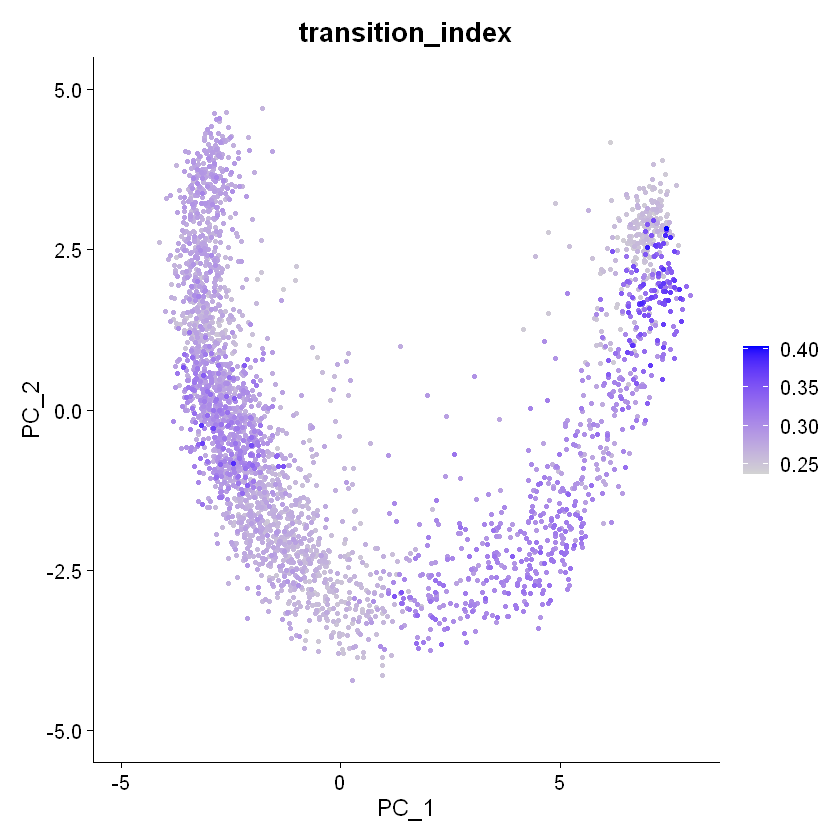

In [24]:
# UMAP 按 Transition Index 着色
FeaturePlot(data, reduction = "pca", features = 'transition_index', order = TRUE, pt.size = 1)

In [ ]:
write.table(data$transition_index, 
            file = data_name+"/transition_index.csv",
            row.names = FALSE,
            col.names = FALSE,
            sep = ",")